In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import awkward as ak 
import xarray as xr

from pySD.sdmout_src import pysetuptxt
from pySD.sdmout_src import supersdata
from pySD.sdmout_src import sdtracing
from importlib import reload
from pathlib import Path

from sdm_eurec4a.visulization import ncols_nrows_from_N


In [2]:
reload(supersdata)

<module 'pySD.sdmout_src.supersdata' from '/home/m/m301096/CLEO/pySD/sdmout_src/supersdata.py'>

In [3]:
def ak_differentiate(sa : supersdata.SupersAttribute) -> supersdata.SupersAttribute:

    data = sa.data

    # It is verz important, to concate the nan values at the END of the array, so that the last value is nan.
    # This makes sure, that the mass change is at the same timestep, as the original value.
    # With this, the evapoartion fraction can not exceed 1.
    data = ak.concatenate([data, np.nan], axis = -1)

    # if the data has entries, which have only one value, append another nan value
    if ak.min(ak.num(data, axis = -1)) < 2:
        data = ak.concatenate([data, np.nan], axis = -1)
        
    # calculate the difference
    diff = data[..., 1:] - data[..., :-1]
    result = supersdata.SupersAttribute(
        name = sa.name + "_difference", 
        data = diff,
        units = sa.units,
        metadata = sa.metadata.copy(),
    )
    updated_metadata = sa.metadata.copy()
    try : 
        updated_metadata["long_name"] = updated_metadata["long_name"] + " difference"
    except KeyError:
        pass        
    result.set_metadata(
        metadata= updated_metadata
    )
    return result

In [4]:
cluster_number = 193
basepath = Path(f"/home/m/m301096/CLEO/data/newoutput/stationary_condensation/clusters_{cluster_number}/")

eulerian_dataset_path  = basepath / "processed/"
eulerian_dataset_path.mkdir(exist_ok=True)

figure_path = Path(f'/home/m/m301096/repositories/sdm-eurec4a/notebooks/stationary_analysis/{cluster_number}')
figure_path.mkdir(exist_ok=True)

# basepath = Path("/home/m/m301096/CLEO/data/newoutput/stationary_no_physics/clusters_18/")

setupfile = basepath / "config" / "eurec4a1d_setup.txt"
zarr_dataset =   basepath / "eurec4a1d_sol.zarr"
# read in constants and intial setup from setup .txt file
config = pysetuptxt.get_config(setupfile, nattrs=3, isprint=False)
consts = pysetuptxt.get_consts(setupfile, isprint=False)
# initialize the superdroplets data class


## Understanding the initial radius distribution

---- Superdrop Properties -----
RHO_L = 998.203 Kg/m^3
RHO_SOL = 2016.5 Kg/m^3
MR_SOL = 0.05844277 Kg/mol
IONIC = 2.0
-------------------------------
supers dataset:  /home/m/m301096/CLEO/data/newoutput/stationary_condensation/clusters_193/eurec4a1d_sol.zarr
Attribute coord1 not found in dataset
Attribute coord2 not found in dataset


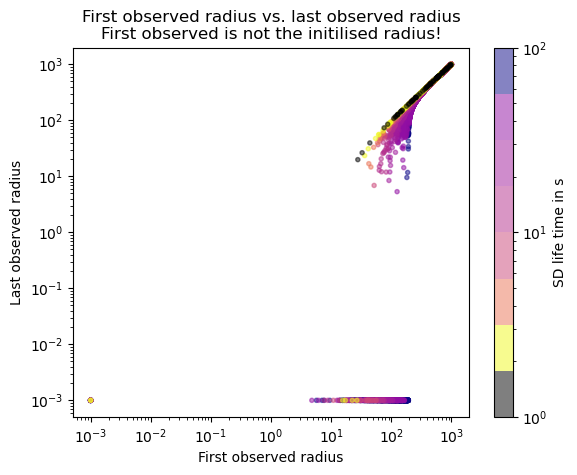

In [5]:
sddata = supersdata.SupersDataNew(str(zarr_dataset), consts)

# make time an indexer which correspondataset to the unique values of the time attribute
sddata.set_attribute(
    sddata["time"].attribute_to_indexer_unique()
)
# make time an indexer which correspondataset to the unique values of the time attribute
sddata.set_attribute(
    sddata["sdgbxindex"].attribute_to_indexer_unique(new_name = "gridbox")
)

# make time an indexer which correspondataset to the unique values of the time attribute
sddata.set_attribute(
    sddata["sdId"].attribute_to_indexer_unique()
)


sddata.index_by_indexer(index = sddata["sdId"])
life_time_array = sddata.get_data("time")[:,-1] - sddata.get_data("time")[:,0]
life_time = np.array([
    0, 1, 5, 10, 15, 20, 25, 100
])
my_cmap = mpl.colormaps["plasma_r"]
my_norm = mpl.colors.LogNorm(vmin=None, vmax=np.max(life_time))
my_cmap = mpl.colors.ListedColormap(my_cmap(my_norm(life_time)), name='myColorMap')

fig, ax = plt.subplots(1,1)

sc = ax.scatter(
    sddata.get_data("radius")[:,0],
    sddata.get_data("radius")[:,-1],
    c = life_time_array,
    marker = ".",
    alpha = 0.5,
    norm = my_norm,
    cmap = my_cmap,

)
fig.colorbar(ax = ax, mappable = sc, label = "SD life time in s")

ax.set_xscale("log")
ax.set_yscale('log')
ax.set_title("First observed radius vs. last observed radius\nFirst observed is not the initilised radius!")
ax.set_xlabel("First observed radius")
ax.set_ylabel("Last observed radius")

fig.savefig(figure_path / "first_vs_last_radius.png", dpi = 500)

## Create Xarray dataset for mass change

In this step, we create the xarray dataset which contains the mass change per gridbox and per radius bin.

> **It should be noted, that the binning of radius is NOT binning by the radius when leaving the cloud.**

### Steps:
1. Create indexes from ``time``, ``sdId``, ``gridbox``
2. Bin by ``sdId`` (lagrangian) and calculate the mass change for each droplet.
3. Flatten the array again (remove the coordinate) as preparation for the eulerian transformation
4. Create Eulerian view by binning by ``time``, ``gridbox``, ``radius_bins``

In [6]:
sddata = supersdata.SupersDataNew(str(zarr_dataset), consts)


# ============
# 1.
# ============
# make time an indexer which correspondataset to the unique values of the time attribute
sddata.set_attribute(
    sddata["time"].attribute_to_indexer_unique()
)
# make time an indexer which correspondataset to the unique values of the time attribute
sddata.set_attribute(
    sddata["sdgbxindex"].attribute_to_indexer_unique(new_name = "gridbox")
)

# make time an indexer which correspondataset to the unique values of the time attribute
sddata.set_attribute(
    sddata["sdId"].attribute_to_indexer_unique()
)


# make a  binned radius indexer.
bins = np.logspace(-7, 7, 150)
sddata.set_attribute(
    sddata["radius"].attribute_to_indexer_binned(bins=bins, new_name = "radius_bins")
)

# ============
# 2.
# ============


# bin by the superdroplet id and calcuate the difference of the mass
sddata.index_by_indexer(index = sddata["sdId"])



# calculate the difference of the mass
mass_rep_diff = ak_differentiate(sddata["mass_represented"]) # / ak_differentiate(sddata["time"])
mass_rep_diff.set_metadata(
    metadata = {
        "long_name" : "mass represented difference",
    }
)
mass_rep_diff.set_name("mass_represented_difference_total")
sddata.set_attribute(mass_rep_diff)

mass_diff = ak_differentiate(sddata["mass_represented"]) / ak_differentiate(sddata["time"])
mass_diff.set_metadata(
    metadata = {
        "long_name" : "mass represented difference per second",
    }
)
sddata.set_attribute(mass_diff)

xi_diff = ak_differentiate(sddata["xi"]) / ak_differentiate(sddata["time"])
xi_diff.set_metadata(
    metadata = {
        "long_name" : "multiplicity difference per second",
    }
)
sddata.set_attribute(xi_diff)

evaporated_fraction = sddata["mass_represented_difference"] / sddata["mass_represented"] * - 100
evaporated_fraction.set_name("evaporated_fraction")
evaporated_fraction.set_metadata(
    metadata = {
        "long_name" : "evaporated fraction per second",
    }
)
evaporated_fraction.set_units("%")
sddata.set_attribute(evaporated_fraction)


# ============
# 3.
# ============

# flatten the data again to create new bins
sddata.flatten()

# ============
# 4.
# ============

sddata.index_by_indexer(index = sddata["time"])
sddata.index_by_indexer(index = sddata["gridbox"])
sddata.index_by_indexer(index = sddata["radius_bins"])


---- Superdrop Properties -----
RHO_L = 998.203 Kg/m^3
RHO_SOL = 2016.5 Kg/m^3
MR_SOL = 0.05844277 Kg/mol
IONIC = 2.0
-------------------------------
supers dataset:  /home/m/m301096/CLEO/data/newoutput/stationary_condensation/clusters_193/eurec4a1d_sol.zarr
Attribute coord1 not found in dataset
Attribute coord2 not found in dataset


### Create the dataarray by using the reduction functions

In [7]:
reduction_map = {
    "mass_represented_difference" : ak.sum,
    "mass_represented_difference_total": ak.sum,
    "mass_represented" : ak.sum,
    "radius" : ak.mean,
    "evaporated_fraction": ak.mean,
    "xi": ak.sum,
    
}

da_list = []
for attribute_name, reduction_func in reduction_map.items():
    da_list.append(
        sddata.attribute_to_DataArray_reduction(
            attribute_name = attribute_name,
            reduction_func = reduction_func,
        )
    )    

dataset = xr.merge(da_list)

dataset["time"].attrs["long_name"] = "time"
dataset["time"].attrs["units"] = "s"

dataset = dataset.where(dataset != 0)
dataset.to_netcdf(
    eulerian_dataset_path / "eulerian_mass_change.nc"
)

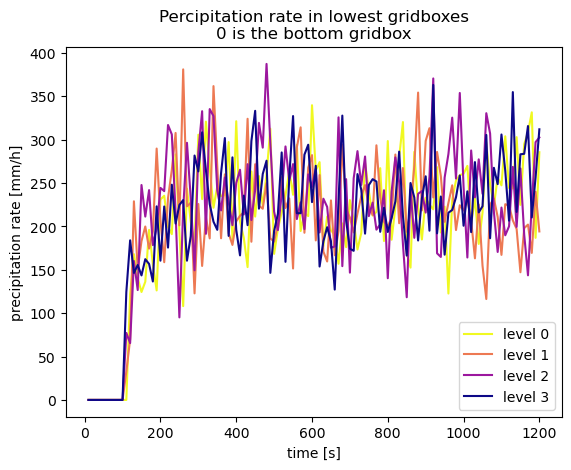

In [8]:
precipitation = 60*60 * (dataset["mass_represented"].sum(dim = "radius_bins")) / dataset["time"].diff(dim = 'time')
precipitation.name = "precipitation"
precipitation.attrs["units"]= "mm/h"
precipitation.attrs["long_name"] = "precipitation rate"

fig, ax = plt.subplots()


grid_indices = dataset["gridbox"].sel(gridbox = slice(0, 3))

my_cmap = mpl.colormaps["plasma_r"]
my_norm = mpl.colors.Normalize(vmin=grid_indices.min(), vmax=grid_indices.max())
colors = my_cmap(my_norm(grid_indices))

for idx in grid_indices.values:
    ax.plot(
        precipitation["time"],
        precipitation.sel(gridbox = idx),
        c = colors[idx],
        label = f"level {idx}"
    )

create_label = lambda da : f"{da.attrs["long_name"]} [{da.attrs["units"]}]"

ax.set_xlabel(create_label(precipitation["time"]))
ax.set_ylabel(create_label(precipitation))
ax.legend()
ax.set_title("Percipitation rate in lowest gridboxes\n0 is the bottom gridbox")

fig.savefig(figure_path / "precipitation.png", dpi = 500)

Text(0.5, 1.0, 'Percipitation rate in lowest gridboxes\n0 is the bottom gridbox')

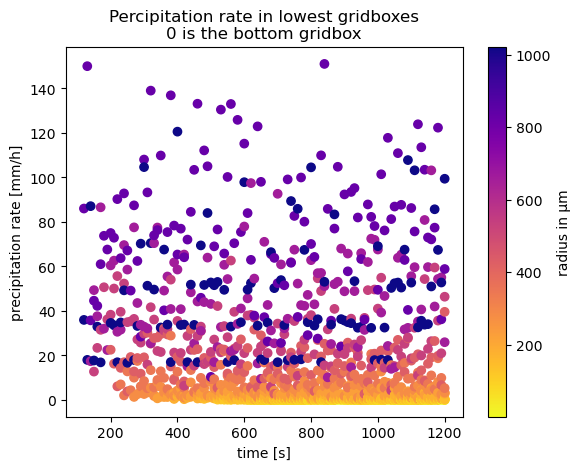

In [11]:
precipitation = 60*60 * (dataset["mass_represented"].isel(gridbox = 0)) / dataset["time"].diff(dim = 'time')
precipitation.name = "precipitation"
precipitation.attrs["units"]= "mm/h"
precipitation.attrs["long_name"] = "precipitation rate"

fig, ax = plt.subplots()


radius_indices = dataset["radius_bins"].sel(radius_bins = slice(1e0, None))

my_cmap = mpl.colormaps["plasma_r"]
my_norm = mpl.colors.Normalize(vmin=radius_indices.min(), vmax=radius_indices.max())
colors = my_cmap(my_norm(radius_indices))

rr, tt = np.meshgrid(precipitation["radius_bins"], precipitation["time"])

sc = ax.scatter(
    tt,
    precipitation,
    c = rr,
    norm = my_norm,
    cmap = my_cmap,
    # label = f"radius {r:.2f}"
)


create_label = lambda da : f"{da.attrs["long_name"]} [{da.attrs["units"]}]"

fig.colorbar(ax = ax, mappable = sc, label = "radius in µm")
ax.set_xlabel(create_label(precipitation["time"]))
ax.set_ylabel(create_label(precipitation))
# ax.legend()
# ax.set_yscale("log")
ax.set_title("Percipitation rate in lowest gridboxes\n0 is the bottom gridbox")

# fig.savefig(figure_path / "precipitation.png", dpi = 500)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

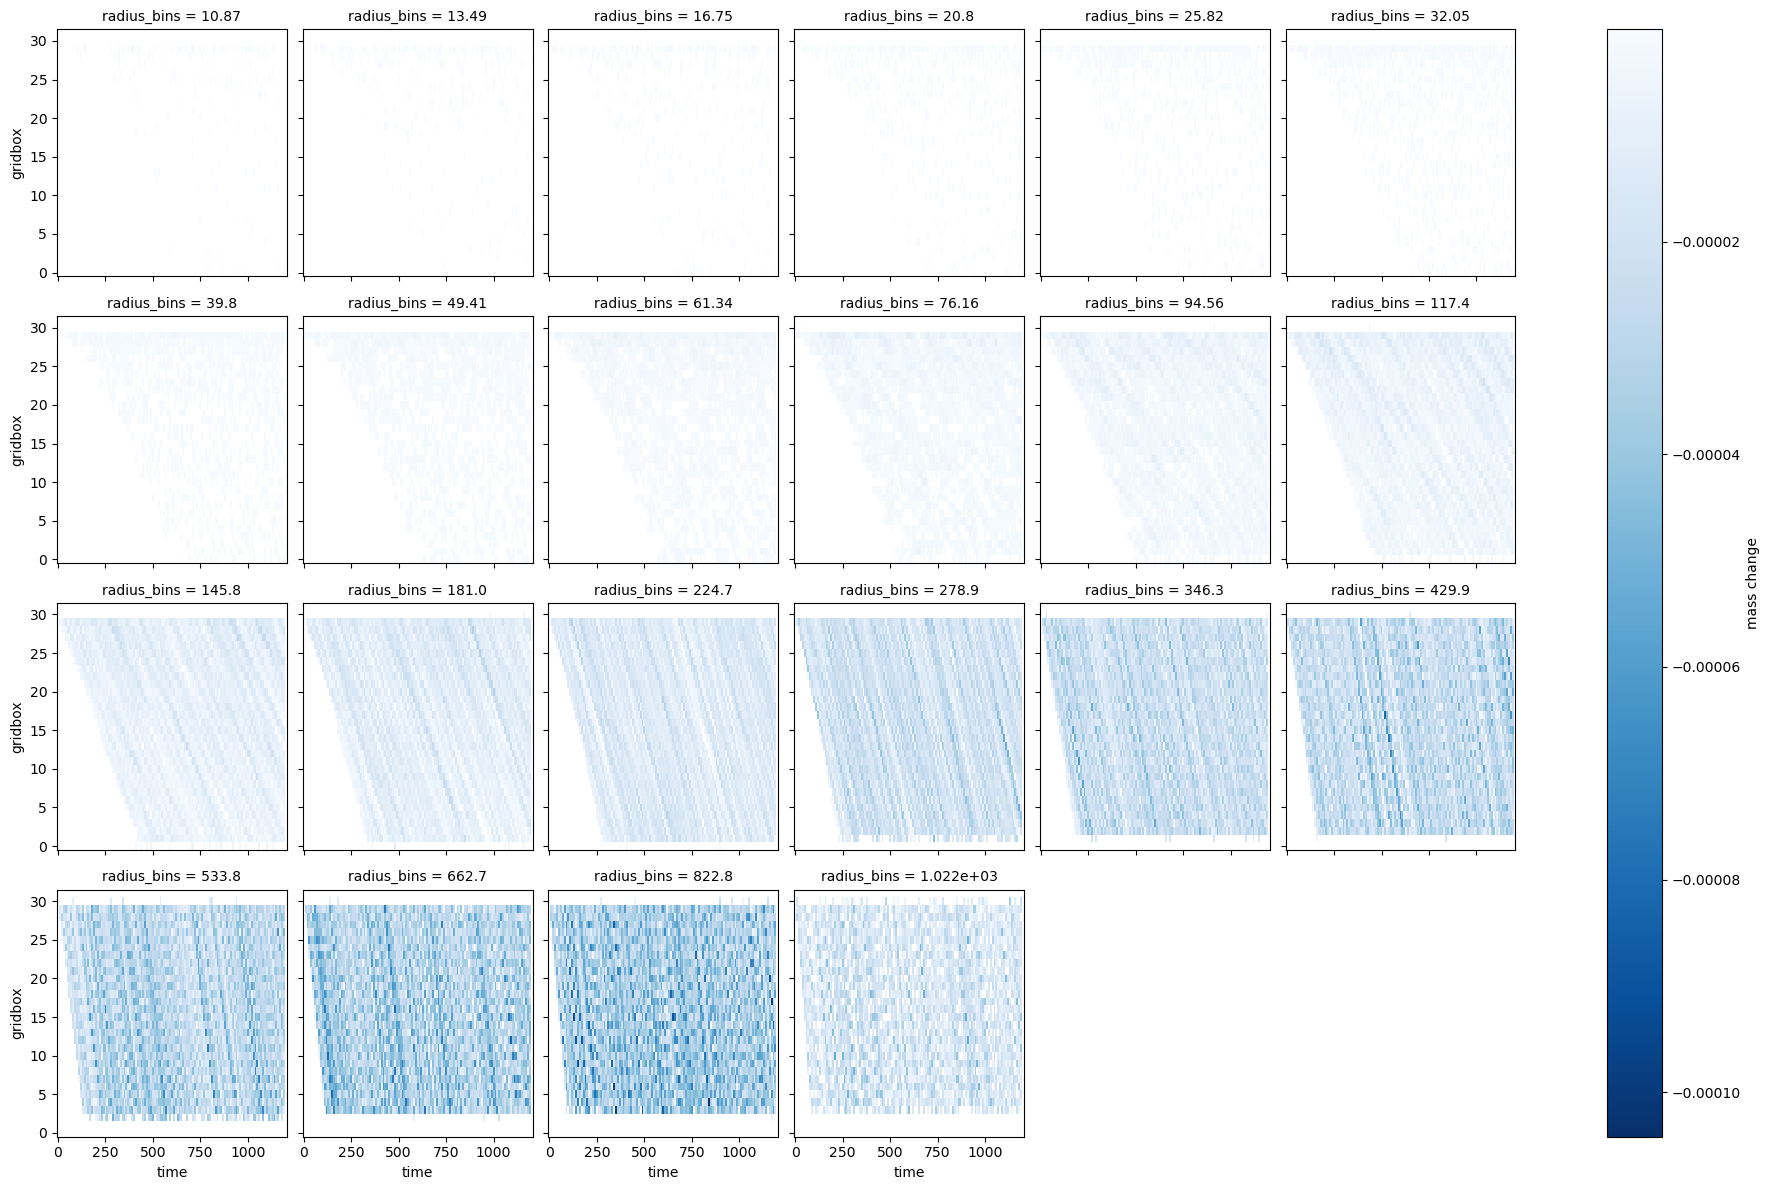

In [ ]:
dataset["mass_represented_difference"].sel(radius_bins = slice(10, None)).plot(x="time", y="gridbox", col="radius_bins", col_wrap=6, cmap="Blues_r", cbar_kwargs={"label": "mass change"})

plt.savefig(figure_path / "mass_represented_difference.png", dpi = 500)

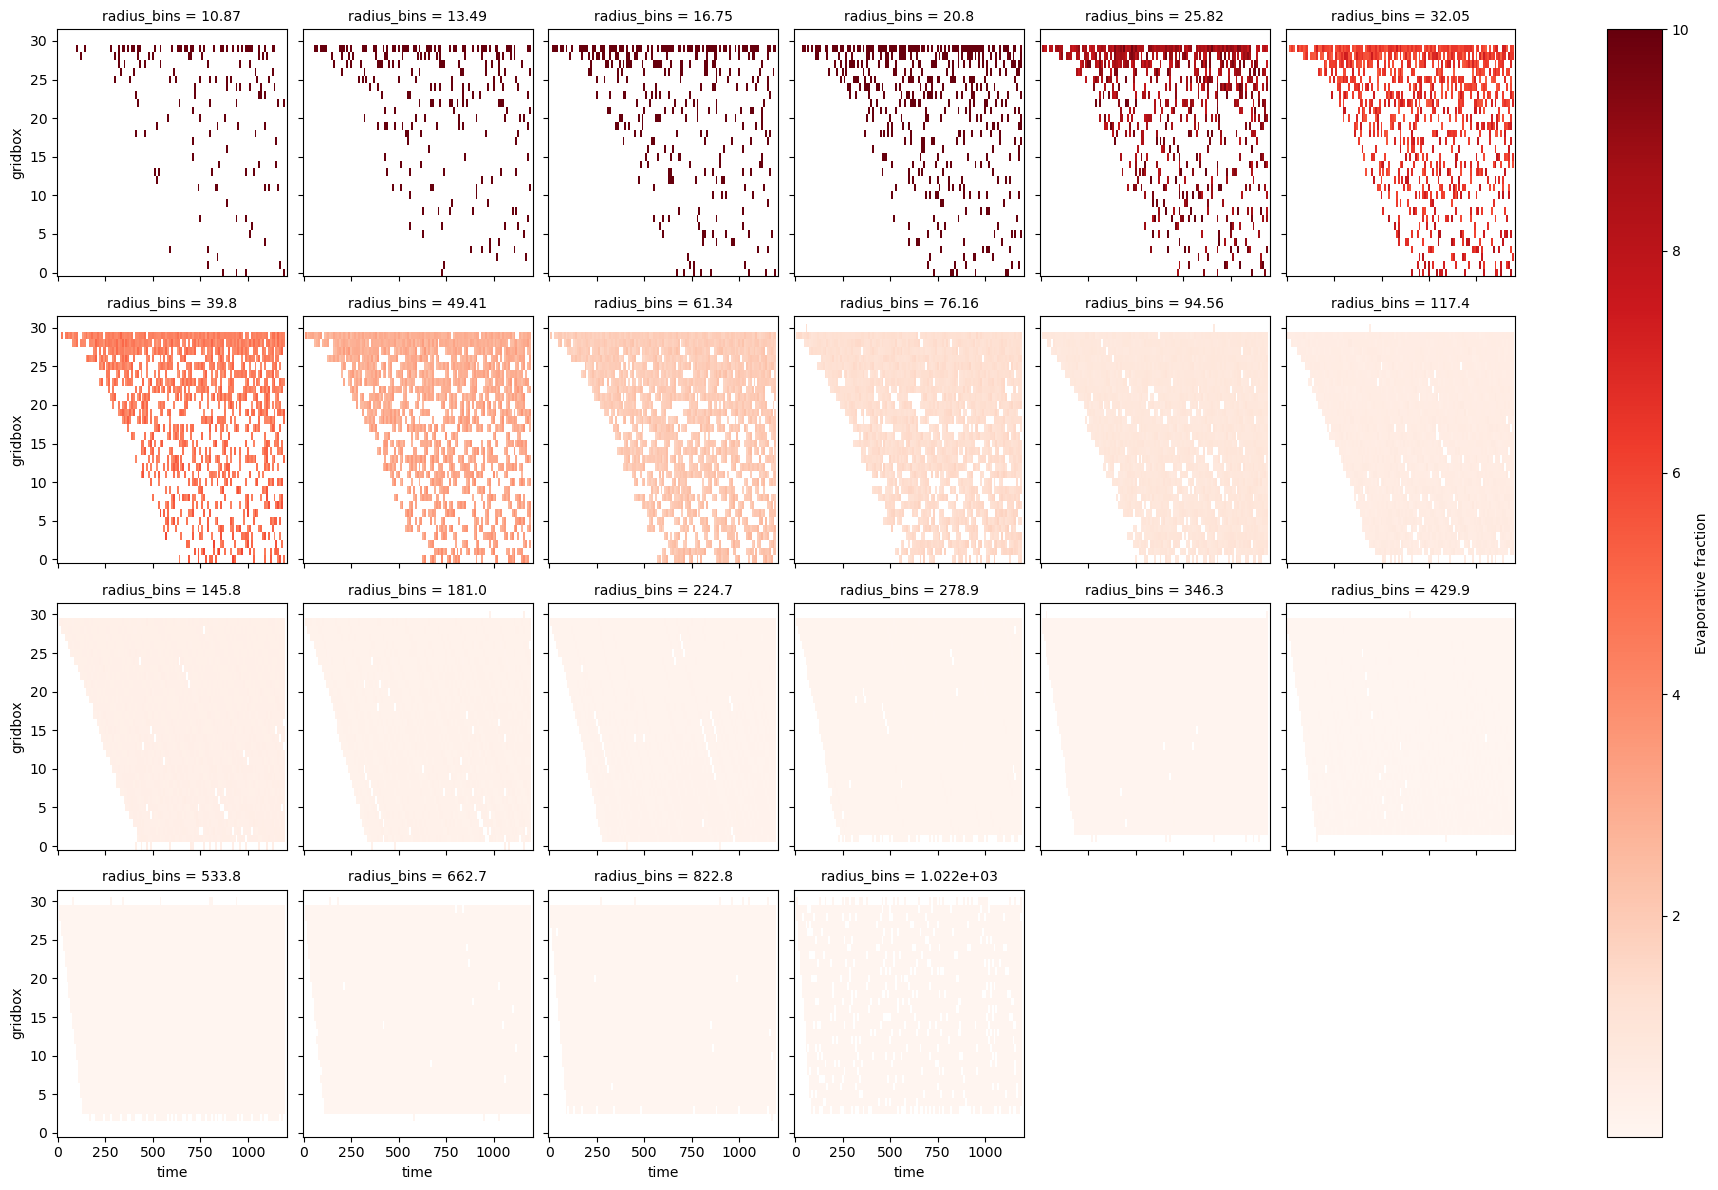

In [ ]:
dataset["evaporated_fraction"].sel(radius_bins = slice(10, None)).plot(x="time", y="gridbox", col="radius_bins", col_wrap=6, cmap="Reds", cbar_kwargs={"label": "Evaporative fraction"})

plt.savefig(figure_path / "evaporated_fraction.png", dpi = 500)

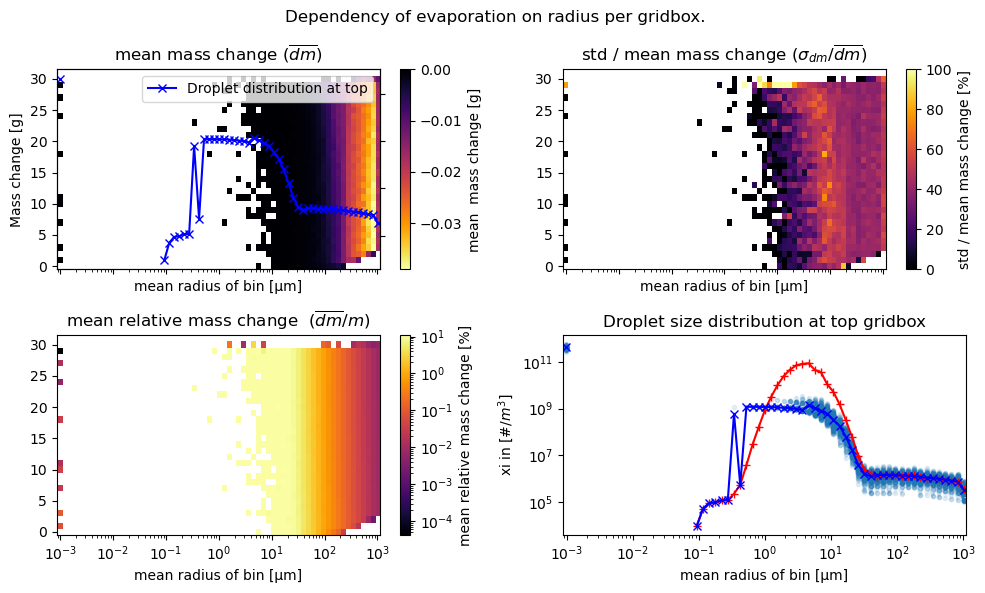

In [ ]:
data = dataset.sel(time = slice(100, None)).sel(radius_bins = slice(0, None)).mean(dim = "time")
data_std = dataset.sel(time = slice(100, None)).sel(radius_bins = slice(0, None)).std(dim = "time")

r_index = data["radius_bins"]
g_index = data["gridbox"]

rr, gg = np.meshgrid(r_index, g_index)

fig, axss = plt.subplots(ncols =2, nrows = 2, sharex = True, figsize = (10,6))

axs = axss.flatten()

my_cmap = mpl.colormaps["inferno_r"]
my_norm = mpl.colors.LogNorm(vmin=data["mass_represented_difference"].min().values, vmax=data["mass_represented_difference"].max().values)


plot_data = {
    "mmc" : dict(
        data = data["mass_represented_difference"] * 1e3,
        cmap = "inferno_r",
        clabel = "mean  mass change [g]",
        title = r"mean mass change ($\overline{dm}$)",
        vmin = None,
        vmax = None,
        norm_func = mpl.colors.Normalize,
    ),
    "srmc" : dict(
        data = - data_std["mass_represented_difference"] / data["mass_represented_difference"] * 100,
        cmap = "inferno",
        clabel = "std / mean mass change [%]",
        title = r"std / mean mass change ($\sigma_{dm} / \overline{dm}$)",
        vmin = 0,
        vmax = 100,
        norm_func = mpl.colors.Normalize,
    ),
    "mrmc" : dict(
        data = - data["mass_represented_difference"] / data["mass_represented"] * 100,
        cmap = "inferno",
        clabel = "mean relative mass change [%]",
        title = r"mean relative mass change  ($\overline{dm} / m$)",
        vmin = None,
        vmax = None,
        norm_func = mpl.colors.LogNorm,
    ),
}

for ax, setup_name in zip(axs.flatten()[:-1], plot_data) :

    setup = plot_data[setup_name]

    da = setup["data"]
    if setup["vmin"] == None:
        vmin = da.min().values
    else :
        vmin = setup["vmin"]
    
    if setup["vmax"] == None:
        vmax = da.max().values
    else :
        vmax = setup["vmax"]    

    my_cmap = mpl.colormaps[setup["cmap"]]
    my_norm = setup["norm_func"](vmin=vmin, vmax=vmax)

    sc = ax.pcolormesh(
        rr, 
        gg,
        da,
        norm = my_norm,
        cmap = my_cmap,
    )
    fig.colorbar(ax = ax, mappable = sc, label = setup["clabel"])
    ax.set_title(setup["title"])

indices = dataset["time"].sel(time = slice(1, None))

my_cmap = mpl.colormaps["plasma_r"]
my_norm = mpl.colors.Normalize(vmin=indices.min(), vmax=indices.max())
colors = my_cmap(my_norm(indices))

ax_twin = axs[0].twinx()
ax_twin.plot(
        dataset["radius_bins"],
        dataset.isel(gridbox = -1).median(dim = "time")["xi"],
        c = "b",
        linestyle = "-",
        marker = "x",
        label = "Droplet distribution at top"
        # alpha = 0.3,
    )
ax_twin.set_yscale("log")
ax_twin.set_yticklabels([])
ax_twin.legend()

for i, idx in enumerate(indices):
    axs[-1].plot(
        dataset["radius_bins"],
        dataset.isel(gridbox = -1).sel(time = idx)["xi"],
        c = "tab:blue",
        linestyle = "-",
        marker = ".",
        alpha = 0.1,
    )



axs[-1].plot(
        dataset["radius_bins"],
        dataset.isel(gridbox = -1).isel(time = 0)["xi"],
        c = "r",
        linestyle = "-",
        marker = "+",
        label = "Droplet distribution at start"
        # alpha = 0.3,
    )
axs[-1].plot(
        dataset["radius_bins"],
        dataset.isel(gridbox = -1).median(dim = "time")["xi"],
        c = "b",
        linestyle = "-",
        marker = "x",
        label = "Forced droplet distribution"
        # alpha = 0.3,
    )



axs[-1].set_xscale("log")
axs[-1].set_yscale("log")
axs[-1].set_title("Droplet size distribution at top gridbox")
axs[-1].set_xlabel("radius bin mean [µm]")
axs[-1].set_ylabel(r"xi in $[\#/m^3]$")	

axs[0].set_ylabel("Mass change [g]")
axs[0].set_xscale("log")

for ax in axs.flatten():
    ax.set_xlabel("mean radius of bin [µm]")

fig.suptitle("Dependency of evaporation on radius per gridbox.")

fig.tight_layout()
fig.savefig(figure_path / "evaporation_radius_dependency.png", dpi = 500)

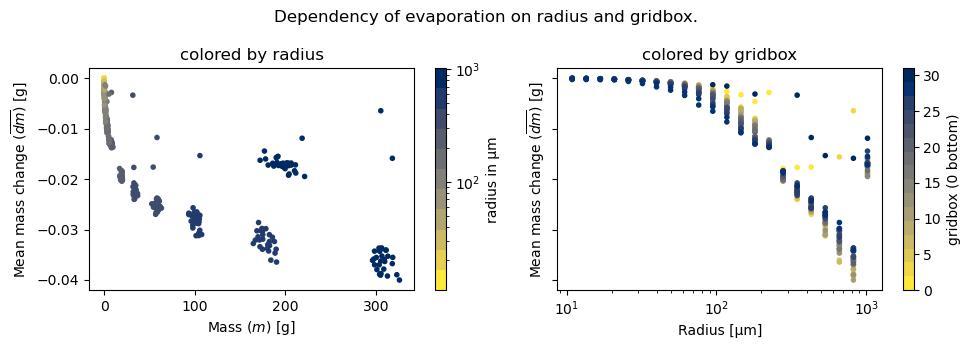

In [ ]:
data = dataset.sel(time = slice(400, None)).sel(radius_bins = slice(1e1, None)).mean(dim = "time")
r_index = data["radius_bins"]
rr = data["mass_represented"] * 0 + r_index
g_index = data["gridbox"]
gg = data["mass_represented"] * 0 + g_index


fig, axs = plt.subplots(ncols =2, sharey = True, figsize = (10,3.5))

my_cmap = mpl.colormaps["cividis_r"]
my_norm = mpl.colors.LogNorm(vmin=r_index.min().values, vmax=r_index.max().values)
my_cmap = mpl.colors.ListedColormap(my_cmap(my_norm(r_index[::2])), name='myColorMap')


sc = axs[0].scatter(
    x = data["mass_represented"] * 1e3, 
    y = data["mass_represented_difference"] * 1e3,
    c = rr,
    # s = ss,
    norm=my_norm,
    cmap = my_cmap,
    marker = '.', 
)
fig.colorbar(ax = axs[0], mappable = sc, label = "radius in µm")


my_cmap = mpl.colormaps["cividis_r"]
my_norm = mpl.colors.Normalize(vmin=g_index.min().values, vmax=g_index.max().values)
my_cmap = mpl.colors.ListedColormap(my_cmap(my_norm(g_index[::2])), name='myColorMap')


sc = axs[1].scatter(
    x = rr, 
    y = data["mass_represented_difference"]* 1e3,
    c = gg,
    # s = ss,
    norm=my_norm,
    cmap = my_cmap,
    marker = '.', 
)
fig.colorbar(ax = axs[1], mappable = sc, label = "gridbox (0 bottom)")


fig.suptitle("Dependency of evaporation on radius and gridbox.")
axs[0].set_title("colored by radius")
axs[1].set_title("colored by gridbox")

axs[0].set_ylabel(r"Mean mass change ($\overline{dm}$) [g]")
axs[0].set_xlabel(r"Mass ($m$) [g]")
axs[1].set_ylabel(r"Mean mass change ($\overline{dm}$) [g]")
axs[1].set_xlabel("Radius [µm]")
axs[1].set_xscale("log")
fig.tight_layout()
fig.savefig(figure_path / "evaporation_radius_dependency_scatter.png", dpi = 500)